In [1]:
# Imported Python files do not automatically reload after you modify them
# M1: Automatically Reload
%load_ext autoreload
%autoreload 2
# M2: Manual Reload
# import importlib
# import ksfdtw
# importlib.reload(ksfdtw)

# https://stackoverflow.com/questions/20309456/how-do-i-call-a-function-from-another-py-file
from ksfdtw import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tslearn.datasets import UCR_UEA_datasets


/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")

In [4]:
# ----------------------------
# Preprocessing Function
# ----------------------------
def preprocess_ts(ts, P, l, final_length=50):
    """Preprocess a single time series and return:
       - preprocessed ts
       - original cutting points (start, end indices)
       - cutting points in the final rescaled ts (indices in [0, final_length])"""
    
    ts = np.asarray(ts)
    if ts.ndim == 1:
        ts = ts[:, np.newaxis]
    original_length = ts.shape[0]
    avg_seg_len = original_length / P
    min_len = int((1 / l) * avg_seg_len)
    max_len = int(l * avg_seg_len)

    segments = []
    cutting_points = []
    interpolated_lengths = []
    start = 0
    for _ in range(P):
        seg_len = random.randint(min_len, max_len)
        end = min(start + seg_len, original_length)
        seg = ts[start:end]
        cutting_points.append((start, end))

        # Rescale this segment to a random new length
        new_L = random.randint(min_len, max_len)
        seg_rescaled = nearest_neighbor_interpolation(seg, new_L)
        interpolated_lengths.append(seg_rescaled.shape[0])
        segments.append(seg_rescaled)

        start = end
        if start >= original_length:
            break

    # Concatenate all interpolated segments
    ts_concat = np.vstack(segments)

    # Compute cutting points on the concatenated sequence (before final rescale)
    cumulative_lengths = np.cumsum(interpolated_lengths)
    final_scale_cuts = np.round(cumulative_lengths / cumulative_lengths[-1] * final_length).astype(int).tolist()

    # Final rescaling to target length
    ts_final = nearest_neighbor_interpolation(ts_concat, final_length)

    return ts_final.squeeze(), cutting_points, final_scale_cuts[:-1]  # exclude final endpoint

In [5]:
# ----------------------------
# Parameters
# ----------------------------
P = 3             # Number of segments
l = 1.5           # Distortion factor
final_L = 50      # Final rescaled length

# ----------------------------
# Preprocess Dataset
# ----------------------------
random.seed(42) 
X_train_scaled, X_train_proc, train_cutting_orig, train_cutting_final = [], [], [], []
for ts in X_train:
    proc, orig_cuts, final_cuts = preprocess_ts(ts, P, l, final_L)
    X_train_scaled.append(nearest_neighbor_interpolation(ts, final_L))
    X_train_proc.append(proc)
    train_cutting_orig.append(orig_cuts)
    train_cutting_final.append(final_cuts)

X_test_scaled, X_test_proc, test_cutting_orig, test_cutting_final = [], [], [], []
for ts in X_test:
    proc, orig_cuts, final_cuts = preprocess_ts(ts, P, l, final_L)
    X_test_scaled.append(nearest_neighbor_interpolation(ts, final_L))
    X_test_proc.append(proc)
    test_cutting_orig.append(orig_cuts)
    test_cutting_final.append(final_cuts)

X_train_proc = np.array(X_train_proc)
X_train_scaled = np.array(X_train_scaled)
X_test_proc = np.array(X_test_proc)
X_test_scaled = np.array(X_test_scaled)

In [6]:
# ----------------------------
# Add Class-Dependent Gaussian Noise
# ----------------------------

# Step 1: Separate by label
X_train_proc = np.array(X_train_proc)
X_test_proc = np.array(X_test_proc)
y_train = np.array(y_train)
y_test = np.array(y_test)

positive_indices = np.where(y_train == y_train[0])[0]
negative_indices = np.where(y_train != y_train[0])[0]

# Step 2: Compute max per class
max_pos = np.max(X_train_proc[positive_indices])
max_neg = np.max(X_train_proc[negative_indices])

# Step 3: Compute variances
var_pos = 0.05 * max_pos
var_neg = 0.05 * max_neg

# Step 4: Add noise
def add_class_dependent_noise(X, y, var_pos, var_neg, pos_label):
    noisy_X = []
    for xi, yi in zip(X, y):
        if yi == pos_label:
            noise = np.random.normal(loc=0.0, scale=var_pos, size=xi.shape)
        else:
            noise = np.random.normal(loc=0.0, scale=var_neg, size=xi.shape)
        noisy_X.append(xi + noise)
    return np.array(noisy_X)

X_train_proc_noisy = add_class_dependent_noise(X_train_proc, y_train, var_pos, var_neg, y_train[0])
X_test_proc_noisy = add_class_dependent_noise(X_test_proc, y_test, var_pos, var_neg, y_train[0])


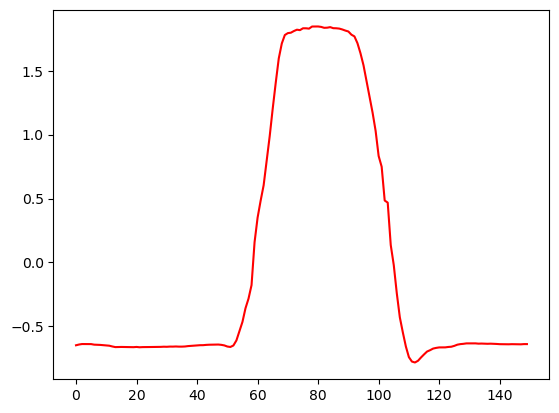

In [7]:
plt.plot(X_train[0], color="red")

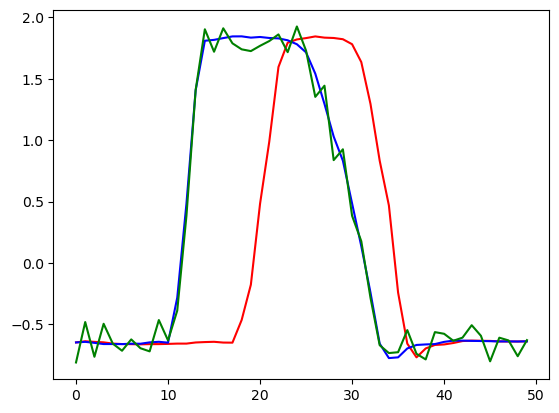

In [8]:
plt.plot(X_train_scaled[0], color="red")
plt.plot(X_train_proc[0], color="blue")
plt.plot(X_train_proc_noisy[0], color="green")
plt.show()

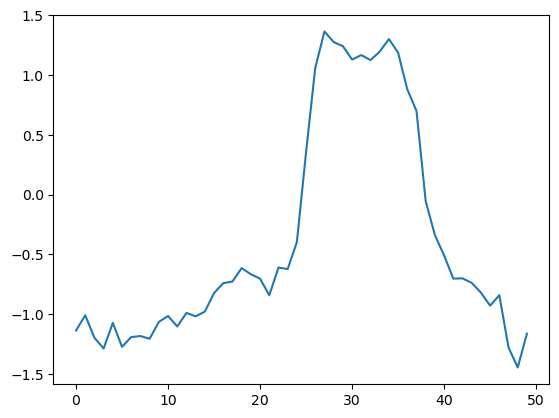

In [9]:
plt.plot(X_test_proc_noisy[0])

In [10]:
np.savez("../data/gunpoint_preprocessed_with_cuts.npz",
    X_train=X_train_scaled,
    X_train_proc=X_train_proc,
    X_train_proc_noisy=X_train_proc_noisy,
    y_train=y_train,
    X_test=X_test_scaled,
    X_test_proc=X_test_proc,
    X_test_proc_noisy=X_test_proc_noisy,
    y_test=y_test,
    train_cutting_orig=train_cutting_orig,
    train_cutting_final=train_cutting_final,
    test_cutting_orig=test_cutting_orig,
    test_cutting_final=test_cutting_final)

In [11]:
X_train.shape

(50, 150, 1)